In [2]:
#base env
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
import time
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import LogisticRegression

from thundersvm import SVC
# from sklearn.svm import SVC

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score



----
# 1.Data Preparation

In [3]:
df = pd.read_csv('./og_data/0.csv')

In [3]:
def zero_one_map(x):
    if x!=0:
        return 1
    else:
        return 0
# df['trip_m6_wd_am'] = df['trip_m6_wd_am'].apply(zero_one_map)




In [4]:
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

In [5]:
def data_processing(df):
    df.columns=['ori','dst','dist_km','fsize_m_wd_am','trip_m_wd_am',\
                        'community_m','mrt_km_o','entro_o','cycle_km_o','far_hdb_o',\
                            'far_priv_o','far_comm_o','mrt_km_d','entro_d','cycle_km_d',\
                                'far_hdb_d','far_priv_d','far_comm_d']
    df['trip_m_wd_am'] = df['trip_m_wd_am'].apply(zero_one_map)
    df.drop(['ori','dst'], inplace=True, axis=1)
    X_train, X_test, y_train, y_test = train_test_split(df.drop('trip_m_wd_am',axis=1),df['trip_m_wd_am'],test_size=0.2, random_state=0)
    
    train_col = X_train.columns
    test_col = X_test.columns

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.fit_transform(X_test)

    X_train = pd.DataFrame(X_train, columns=train_col)
    X_test = pd.DataFrame(X_test, columns=test_col)
    y_train = y_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)

    X_train['far_comm_oxfar_hdb_o'] = X_train['far_comm_o'] * X_train['far_hdb_o']
    X_test['far_comm_oxfar_hdb_o'] = X_test['far_comm_o'] * X_test['far_hdb_o']
    X_train['community_mxdist_km'] = X_train['community_m'] * X_train['dist_km']
    X_test['community_mxdist_km'] = X_test['community_m'] * X_test['dist_km']
    
    selected = ['dist_km', 'fsize_m_wd_am', 'community_m', 'entro_o', 'far_hdb_o',\
                        'far_comm_o', 'mrt_km_d', 'far_priv_d', 'far_comm_d',\
                        'far_comm_oxfar_hdb_o', 'community_mxdist_km']
    
    X_train = X_train[selected]
    X_test = X_test[selected]
    train_data = pd.concat([X_train,y_train],axis=1)
    test_data = pd.concat([X_test,y_test],axis=1)   
    return X_train, X_test, y_train, y_test, train_data, test_data
    
def unselect_data_processing(df):
    df.columns=['ori','dst','dist_km','fsize_m_wd_am','trip_m_wd_am',\
                        'community_m','mrt_km_o','entro_o','cycle_km_o','far_hdb_o',\
                            'far_priv_o','far_comm_o','mrt_km_d','entro_d','cycle_km_d',\
                                'far_hdb_d','far_priv_d','far_comm_d']
    df['trip_m_wd_am'] = df['trip_m_wd_am'].apply(zero_one_map)
    df.drop(['ori','dst'], inplace=True, axis=1)
    X_train, X_test, y_train, y_test = train_test_split(df.drop('trip_m_wd_am',axis=1),df['trip_m_wd_am'],test_size=0.2, random_state=0)
    
    train_col = X_train.columns
    test_col = X_test.columns

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.fit_transform(X_test)

    X_train = pd.DataFrame(X_train, columns=train_col)
    X_test = pd.DataFrame(X_test, columns=test_col)
    y_train = y_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)
    
    train_data = pd.concat([X_train,y_train],axis=1)
    test_data = pd.concat([X_test,y_test],axis=1)   
    
    return X_train, X_test, y_train, y_test, train_data, test_data

----
# 2.1 选择criterion和特征

In [33]:
# tree_model = DecisionTreeClassifier(criterion="entropy")
# tree_model.fit(X_train,y_train)
# print(tree_model.score(X_test,y_test))

0.7849444536561101


In [34]:
# tree_model = DecisionTreeClassifier(criterion="gini")
# tree_model.fit(X_train,y_train)
# print(tree_model.score(X_test,y_test))

0.777959708174432


In [44]:
df.columns=['ori','dst','dist_km','fsize_m_wd_am','trip_m_wd_am',\
                        'community_m','mrt_km_o','entro_o','cycle_km_o','far_hdb_o',\
                            'far_priv_o','far_comm_o','mrt_km_d','entro_d','cycle_km_d',\
                                'far_hdb_d','far_priv_d','far_comm_d']
df['trip_m_wd_am'] = df['trip_m_wd_am'].apply(zero_one_map)
df.drop(['ori','dst'], inplace=True, axis=1)
X_train, X_test, y_train, y_test = train_test_split(df.drop('trip_m_wd_am',axis=1),df['trip_m_wd_am'],test_size=0.2, random_state=0)

train_col = X_train.columns
test_col = X_test.columns

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

X_train = pd.DataFrame(X_train, columns=train_col)
X_test = pd.DataFrame(X_test, columns=test_col)

In [45]:
scores = make_mi_scores(X_train, y_train)

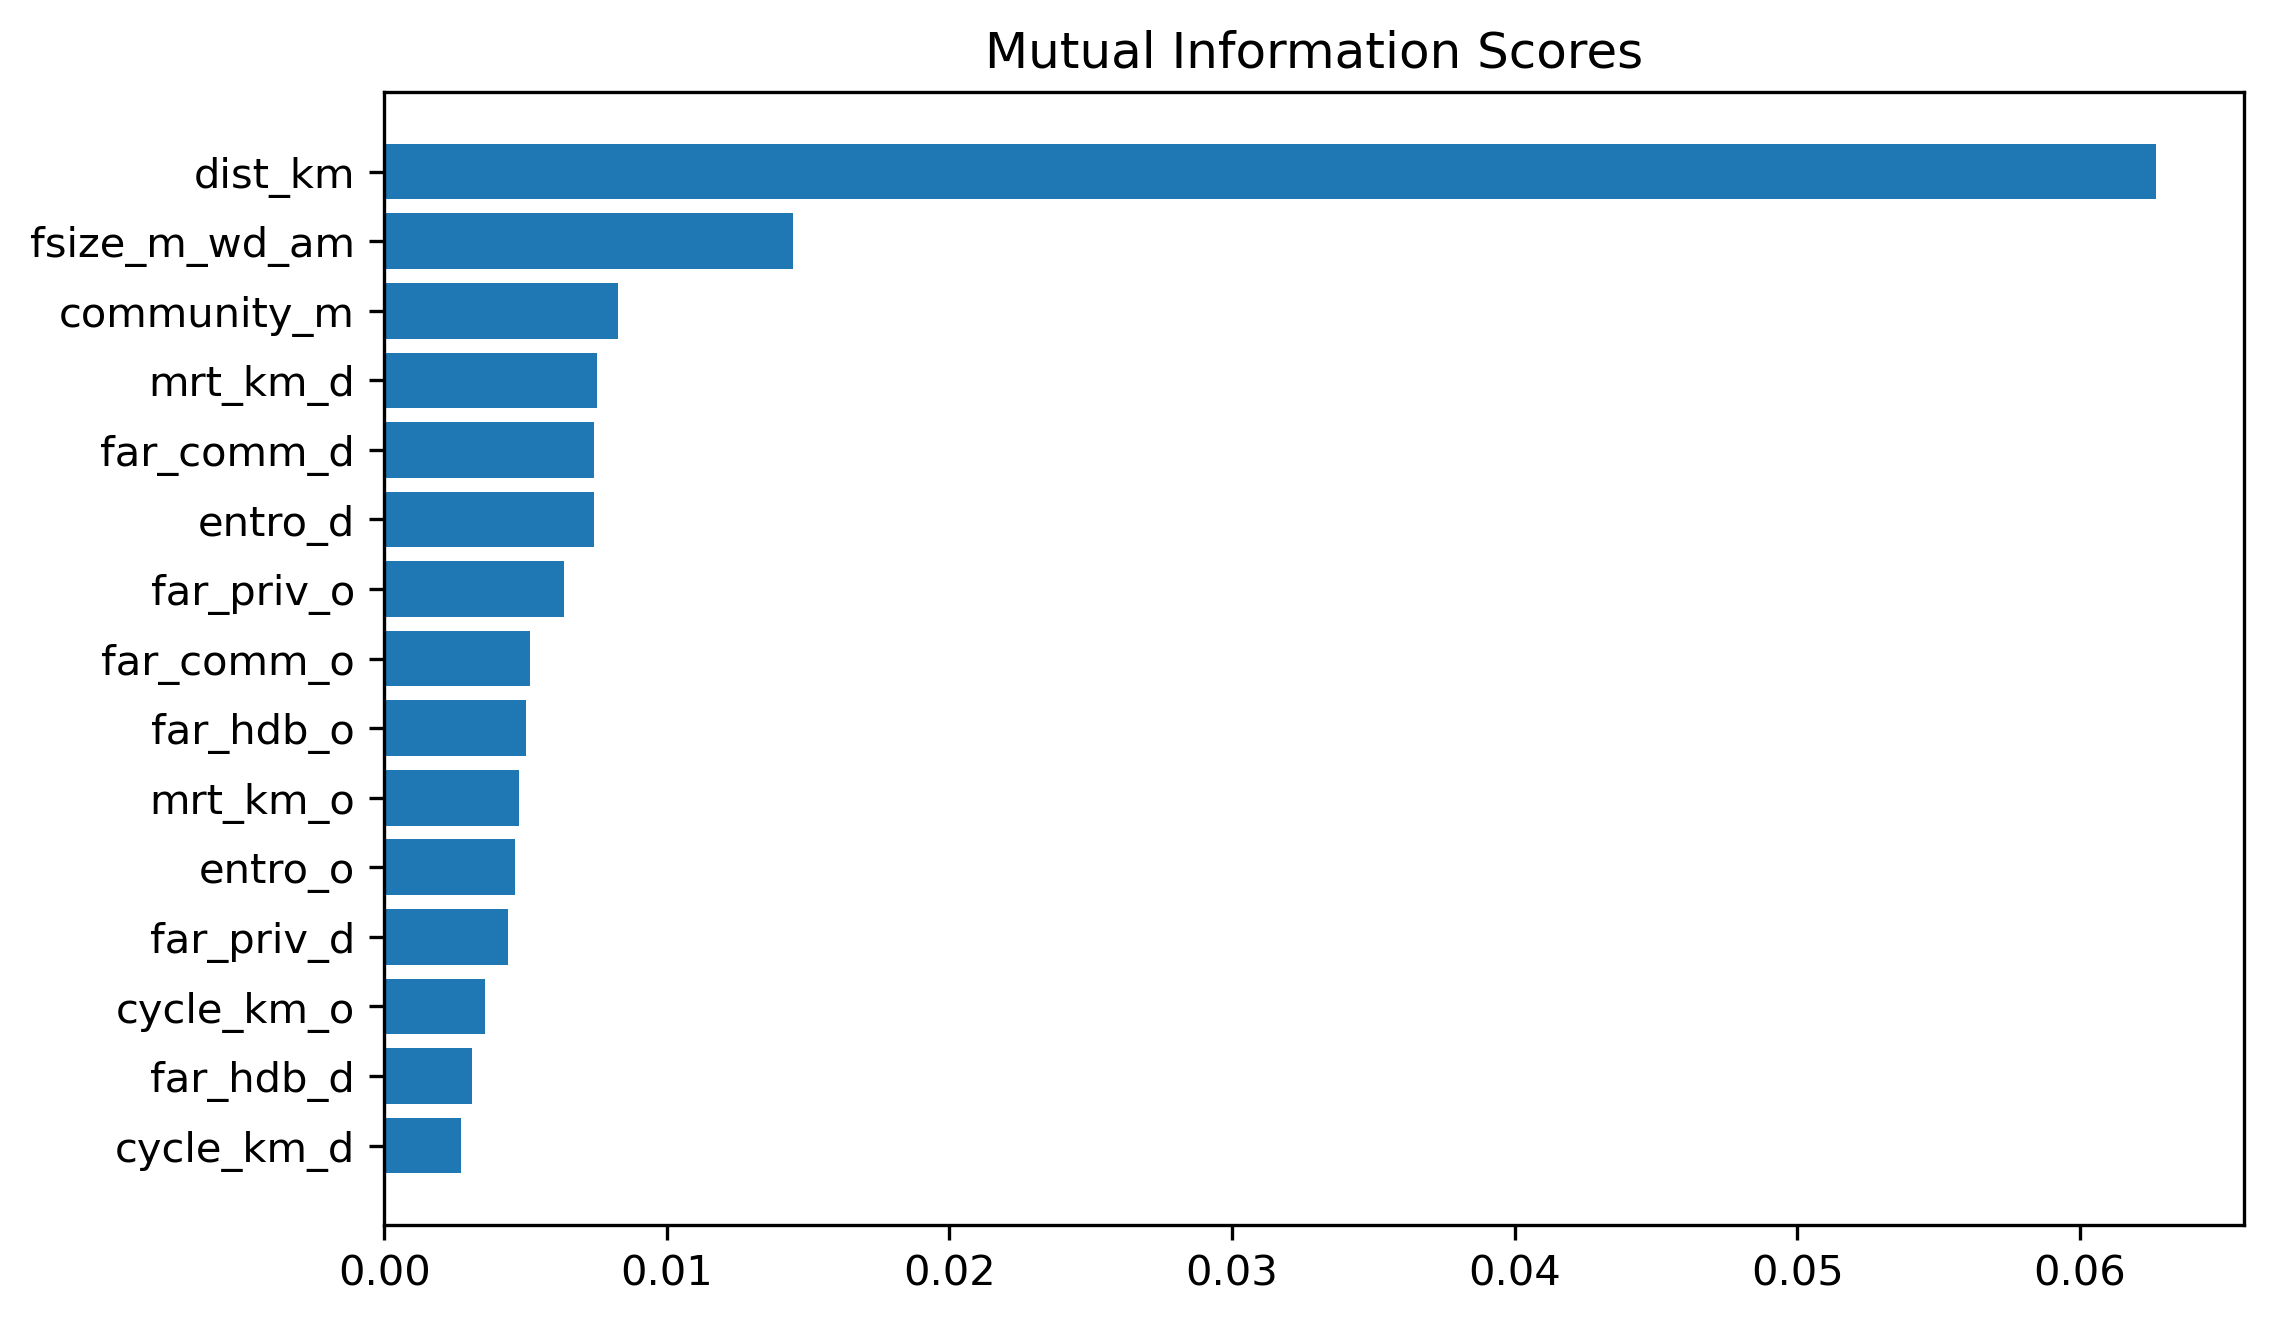

In [46]:
plt.figure(figsize=[8,5],dpi=300)

plot_mi_scores(scores)

plt.savefig('./pics/information_scores0.png')

In [6]:
df = pd.read_csv('./og_data/0.csv')
X_train, X_test, y_train, y_test, train_data, test_data = data_processing(df)

In [ ]:
tree_model = DecisionTreeClassifier(criterion="entropy")
tree_model.fit(X_train[['dist_km', 'fsize_m_wd_am', 'community_m', 'entro_o', 'far_hdb_o',\
                        'far_comm_o', 'mrt_km_d', 'far_priv_d', 'far_comm_d',\
                        'far_comm_oxfar_hdb_o', 'community_mxdist_km']],y_train)
print(tree_model.score(X_test[['dist_km', 'fsize_m_wd_am', 'community_m', 'entro_o', 'far_hdb_o',\
                        'far_comm_o', 'mrt_km_d', 'far_priv_d', 'far_comm_d',\
                        'far_comm_oxfar_hdb_o', 'community_mxdist_km']],y_test))

0.7846335599403084


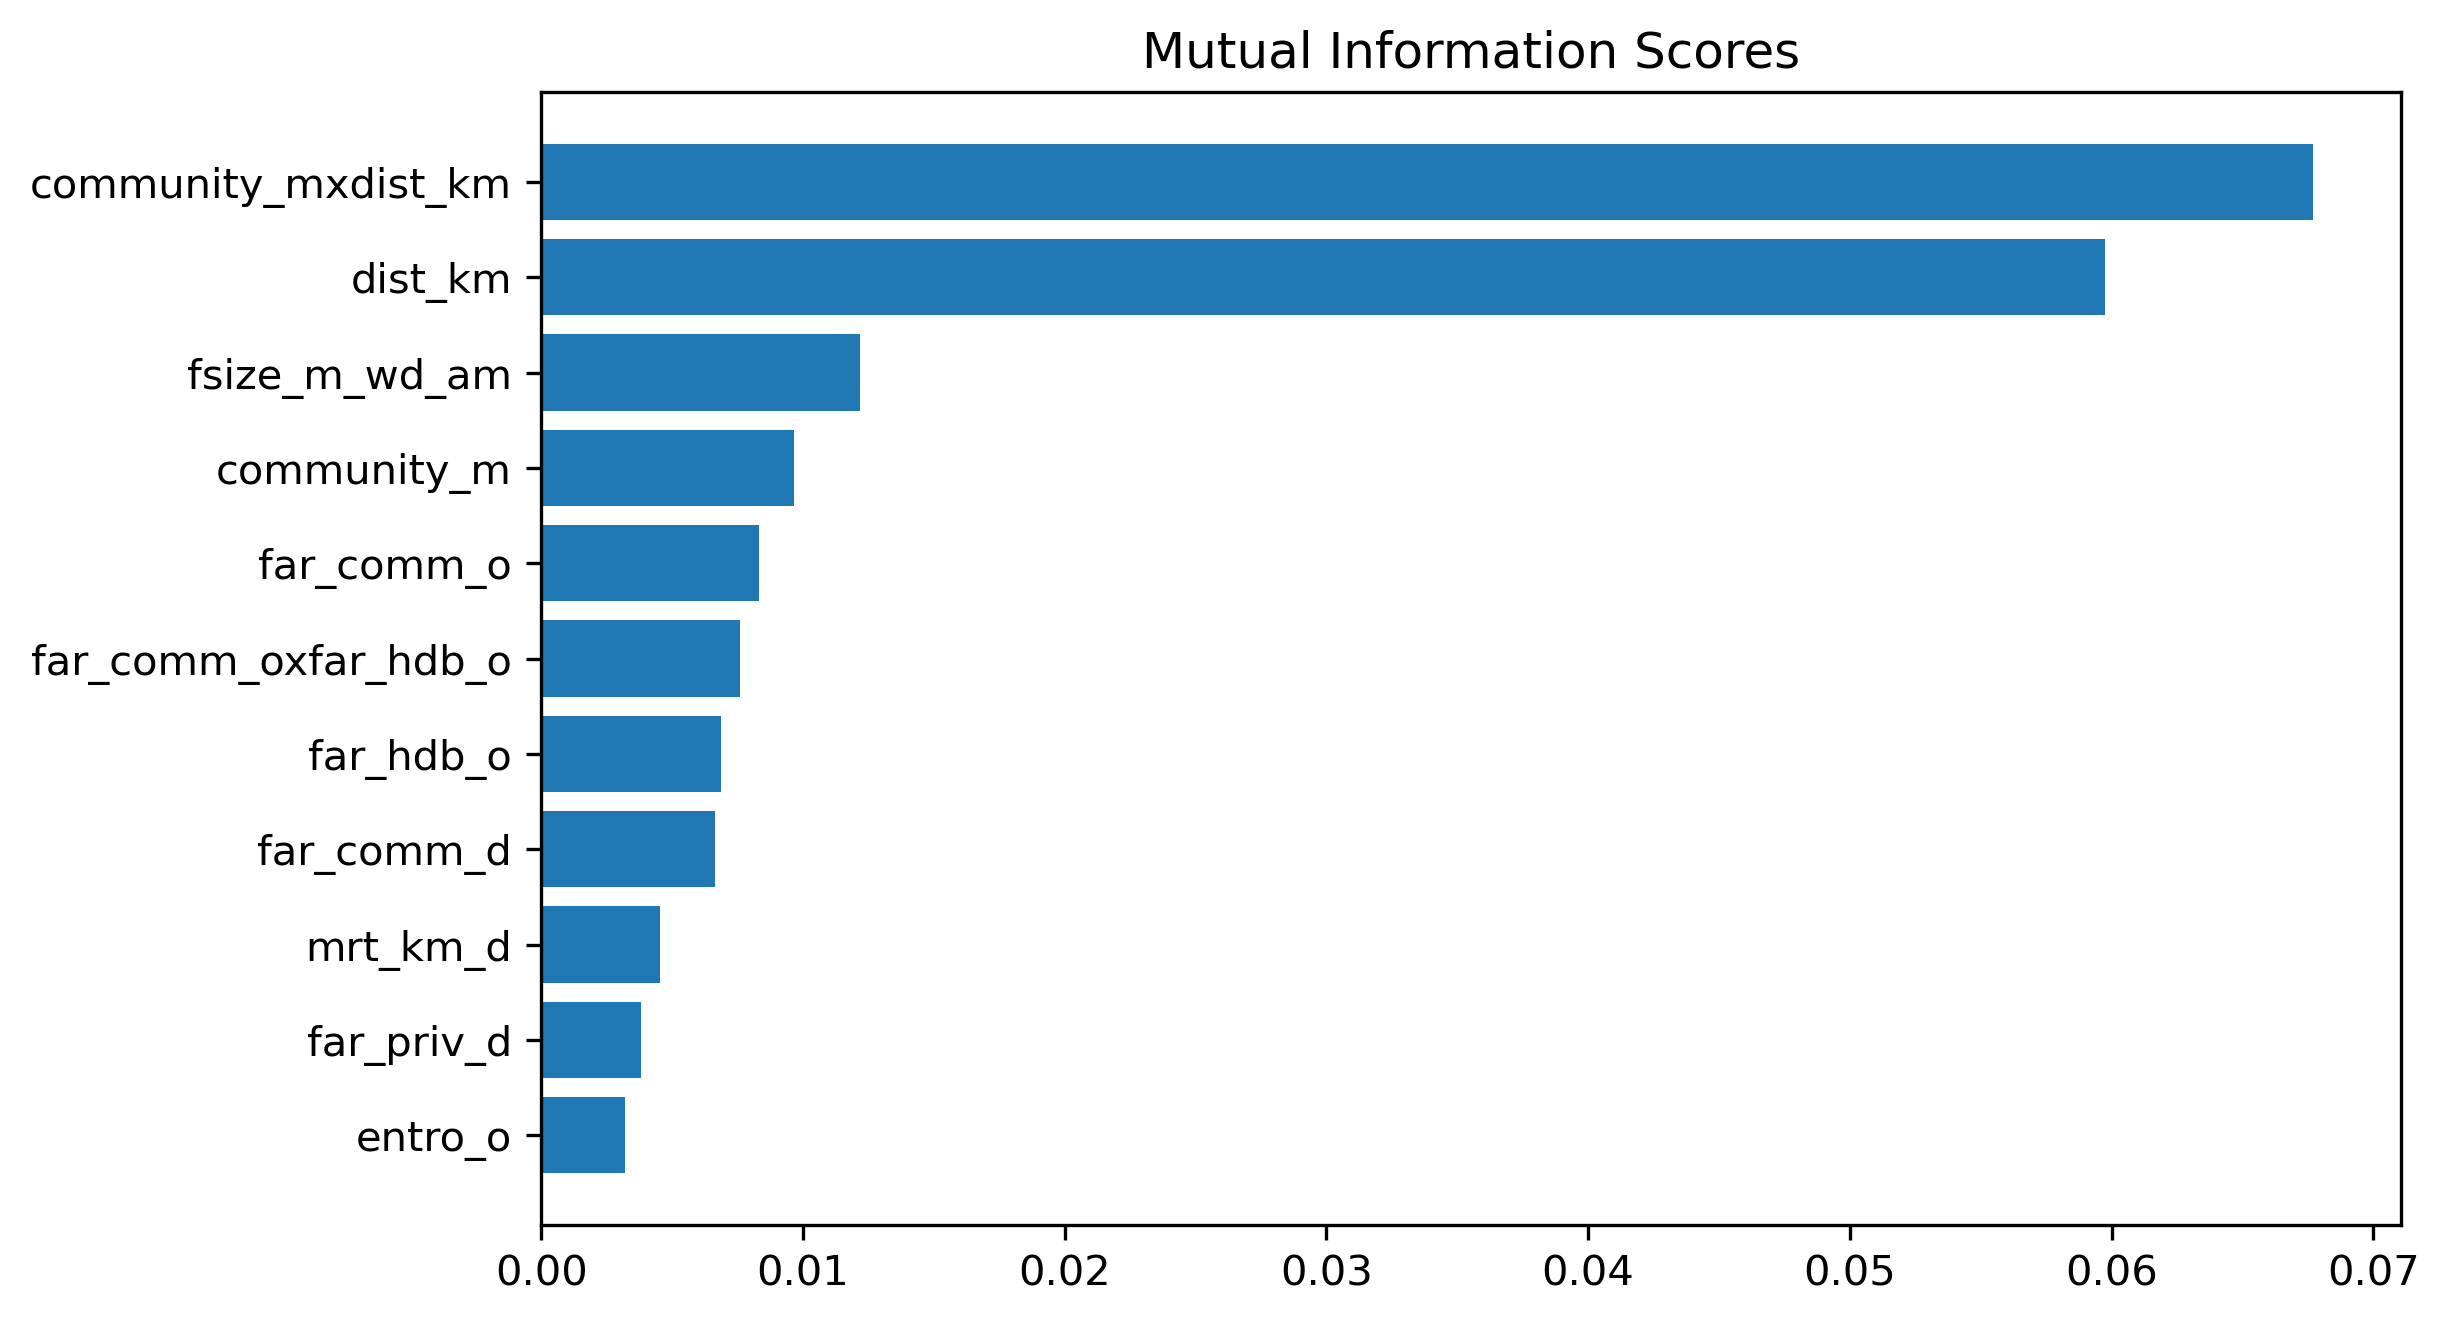

In [41]:
plt.figure(figsize=[8,5],dpi=300)
scores = make_mi_scores(X_train[['dist_km', 'fsize_m_wd_am', 'community_m', 'entro_o', 'far_hdb_o',\
                        'far_comm_o', 'mrt_km_d', 'far_priv_d', 'far_comm_d',\
                        'far_comm_oxfar_hdb_o', 'community_mxdist_km']], y_train)
plot_mi_scores(scores)
plt.savefig('./pics/information_scores1.png')

In [6]:
X_train = X_train[selected]
X_test = X_test[selected]
train_data = pd.concat([X_train,y_train],axis=1)
test_data = pd.concat([X_test,y_test],axis=1)

----
# 2.2 选择其他参数

In [ ]:
# 准确度：aucroc、运算效率：time、鲁棒性：多数据集
# 1.max_depth，min_samples_split2，min_samples_leaf1，max_leaf_nodes

1. 结构

树最大深度max_depth:决定每棵树的最大深度。一般来说，数据少或者特征少的时候可以不管这个值。如果模型样本量多，特征也多的情况下，推荐限制这个最大深度，具体的取值取决于数据的分布。常用的可以取值10-100之间。

最大叶子结点数mas_leaf_nodes:一般情况下，决策树的深度越深，叶节点个数越多，树的复杂度越高。随机森林的复杂度与训练样本数和树的个数成正比。max_leaf_nodes 通过限制最大叶子节点数，可以防止过拟合，默认是"None”，即不限制最大的叶子节点数。如果加了限制，算法会建立在最大叶子节点数内最优的决策树。如果特征不多，可以不考虑这个值，但是如果特征分成多的话，可以加以限制具体的值可以通过交叉验证得到。

2. 剪枝

min_samples_split 如果某节点的样本数少于min_samples_split，则不会继续再尝试选择最优特征来进行划分如果样本量不大，不需要管这个值。如果样本量数量级非常大，则推荐增大这个值。

min_samples_leaf 这个值限制了叶子节点最少的样本数，如果某叶子节点数目小于样本数，则会和兄弟节点一起被剪枝，如果样本量不大，不需要管这个值，大些如10W可是尝试下5

min_weight_fraction_leaf 这个值限制了叶子节点所有样本权重和的最小值，如果小于这个值，则会和兄弟节点一起被剪枝默认是0，就是不考虑权重问题。一般来说，如果我们有较多样本有缺失值，或者分类树样本的分布类别偏差很大，就会引入样本权重，这时我们就要注意这个值了。



9.class_weight = “balanced” 指定样本各类别的的权重，主要是为了防止训练集某些类别的样本过多导致训练的决策树过于偏向这些类别。这里可以自己指定各个样本的权重如果使用“balanced”，则算法会自己计算权重，样本量少的类别所对应的样本权重会高。

min_impurity_decrease 这个值限制了决策树的增长，如果某节点的不纯度(基尼系数，信息增益，均方差，绝对差)小于这个阈值则该节点不再生成子节点。即为叶子节点 。



In [9]:
def params_search_tree(confirmed_params, params):
    estimator = DecisionTreeClassifier(**confirmed_params)
    grid_search0 = GridSearchCV(estimator=estimator, 
                        return_train_score=True,
                        n_jobs=-1, 
                        param_grid=params, 
                        scoring='roc_auc')
    
    grid_search0.fit(X_train, y_train)
    print('best score:',grid_search0.best_score_, grid_search0.best_params_)
    
    confirmed_params.update(grid_search0.best_params_)
    estimator = DecisionTreeClassifier(**confirmed_params)
    estimator.fit(X_train,y_train)
    print('score on test set:',estimator.score(X_test,y_test))
    
    return confirmed_params

In [60]:

confirmed_params = {'criterion': "entropy"}
params0 = {'max_depth':range(1,51,4),
        'max_leaf_nodes':range(81,201,20)}
confirmed_params = params_search_tree(confirmed_params, params0)
confirmed_params

best score: 0.7987687548469358 {'max_depth': 17, 'max_leaf_nodes': 141}
score on test set: 0.8644296136627425


{'criterion': 'entropy', 'max_depth': 17, 'max_leaf_nodes': 141}

In [70]:
confirmed_params = {'criterion': 'entropy', 'max_depth': 17, 'max_leaf_nodes': 141}
params1 = {'min_samples_split':range(2,12,2),
        'min_samples_leaf':range(1,5,2),
        'class_weight':[None, 'balanced'],
        'max_features':['auto', 'sqrt', 'log2']
        }
confirmed_params = params_search_tree(confirmed_params, params1)
confirmed_params

best score: 0.7925400482756719 {'class_weight': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 6}
score on test set: 0.8629373238268944


{'criterion': 'entropy',
 'max_depth': 17,
 'max_leaf_nodes': 141,
 'class_weight': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 6}

In [ ]:
confirmed_params = {'criterion': 'entropy',
                    'max_depth': 17,
                    'max_leaf_nodes': 141,
                    'class_weight': None,
                    'max_features': 'sqrt',
                    'min_samples_leaf': 1,
                    'min_samples_split': 6}

final_tree_model = DecisionTreeClassifier(**confirmed_params)
final_tree_model.fit(X_train,y_train)


In [ ]:
def tree(clf):
    fig = plt.figure(figsize=[50,15],dpi=100)
    plot_tree(clf, fontsize=5)
    fig.savefig('./pics/tree model.jpg')
tree(final_tree_model)
# plt.figure(figsize=[25,8])
# plot_tree(final_tree_model)
# plt.savefig('./pics/tree model.jpg')

----
# 3.1 SVM参数

kernel: string, optional(default='rbf')
set type of kernel function
'linear': u'*v
'polynomial': (gamma*u'*v + coef0)^degree
'rbf': exp(-gamma*|u-v|^2)
'sigmoid': tanh(gamma*u'*v + coef0)
'precomputed' -- precomputed kernel (kernel values in training_set_file)

degree: int, optional(default=3)
set degree in kernel function

gamma: float, optional(default='auto')
set gamma in kernel function (auto:1/num_features)

coef0: float, optional(default=0.0)
set coef0 in kernel function

C: float, optional(default=1.0)
set the parameter C of C-SVC, epsilon-SVR, and nu-SVR

nu: float, optional(default=0.5)
set the parameter nu of nu-SVC, one-class SVM, and nu-SVR

epsilon: float, optional(default=0.1)
set the epsilon in loss function of epsilon-SVR

tol: float, optional(default=0.001)
set tolerance of termination criterion (default 0.001)

probability: boolean, optional(default=False)
whether to train a SVC or SVR model for probability estimates, True or False

class_weight: {dict, 'balanced'}, optional(default=None)
set the parameter C of class i to weight*C, for C-SVC. If not given, all classes are supposed to have weight one. The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y))

shrinking: boolean, optional (default=False, not supported yet for True)
whether to use the shrinking heuristic.

cache_size: float, optional, not supported yet.
specify the size of the kernel cache (in MB).

verbose: bool(default=False)
enable verbose output. Note that this setting takes advantage of a per-process runtime setting; if enabled, ThunderSVM may not work properly in a multithreaded context.

max_iter: int, optional (default=-1)
hard limit on the number of iterations within the solver, or -1 for no limit.

n_jobs: int, optional (default=-1)
set the number of cpu cores to use, or -1 for maximum.

max_mem_size: int, optional (default=-1)
set the maximum memory size (MB) that thundersvm uses, or -1 for no limit.

gpu_id: int, optional (default=0)
set which gpu to use for training.

decision_function_shape: ‘ovo’, default=’ovo’, not supported yet for 'ovr'
only for classifier. Whether to return a one-vs-rest (‘ovr’) decision function of shape (n_samples, n_classes) as all other classifiers, or the original one-vs-one (‘ovo’) decision function of libsvm which has shape (n_samples, n_classes * (n_classes - 1) / 2).

random_state: int, RandomState instance or None, optional (default=None), not supported yet
The seed of the pseudo random number generator to use when shuffling the data. If int, random_state is the seed used by the random number generator; If RandomState instance, random_state is the random number generator; If None, the random number generator is the RandomState instance used by np.random.

Attributes

（1）C: 目标函数的惩罚系数C，用来平衡分类间隔margin和错分样本的，default C = 1.0；

（2）kernel：参数选择有RBF, Linear, Poly, Sigmoid, 默认的是"RBF";

（3）degree：if you choose 'Poly' in param 2, this is effective, degree决定了多项式的最高次幂；

（4）gamma：核函数的系数('Poly', 'RBF' and 'Sigmoid'), 默认是gamma = 1 / n_features;

（5）coef0：核函数中的独立项，'RBF' and 'Poly'有效；

（6）probablity: 可能性估计是否使用(true or false)；

（7）shrinking：是否进行启发式；

（8）tol（default = 1e - 3）: svm结束标准的精度;

（9）cache_size: 制定训练所需要的内存（以MB为单位）；

（10）class_weight: 每个类所占据的权重，不同的类设置不同的惩罚参数C, 缺省的话自适应；

（11）verbose: 跟多线程有关，不大明白啥意思具体；

（12）max_iter: 最大迭代次数，default = 1， if max_iter = -1, no limited;

（13）decision_function_shape ： ‘ovo’ 一对一, ‘ovr’ 多对多 or None 无, default=None

（14）random_state ：用于概率估计的数据重排时的伪随机数生成器的种子。

ps：7,8,9一般不考虑。



其中 C是惩罚系数，即对误差的宽容度。c越高，说明越不能容忍出现误差,容易过拟合。C越小，容易欠拟合。C过大或过小，泛化能力变差

gamma是选择RBF函数作为kernel后，该函数自带的一个参数。隐含地决定了数据映射到新的特征空间后的分布，gamma越大，支持向量越少，gamma值越小，支持向量越多。支持向量的个数影响训练与预测的速度。

In [13]:
svm_df = pd.read_csv('./og_data/0.csv')
svm_df = svm_df.sample(int(len(svm_df)/20))

In [14]:
svm_X_train, svm_X_test, svm_y_train, svm_y_test, svm_train_data, svm_test_data = data_processing(svm_df)

In [17]:

def params_search_svm(confirmed_params, params):
    estimator = SVC(**confirmed_params)
    grid_search0 = GridSearchCV(estimator=estimator, 
                        return_train_score=True,
                        n_jobs=-1, 
                        param_grid=params, 
                        scoring='roc_auc')
    
    grid_search0.fit(svm_X_train, svm_y_train)
    print('best score:',grid_search0.best_score_, grid_search0.best_params_)
    
    confirmed_params.update(grid_search0.best_params_)
    estimator = SVC(**confirmed_params)
    estimator.fit(svm_X_train,svm_y_train)
    print('score on test set:',estimator.score(svm_X_test,svm_y_test))
    
    return confirmed_params



In [19]:
clf = SVC('rbf')
clf.fit(svm_X_train,svm_y_train)
print('score on test set:',clf.score(svm_X_test,svm_y_test))
# 40.6s

score on test set: 0.854537919602155


In [ ]:
clf = SVC('sigmoid')
clf.fit(svm_X_train,svm_y_train)
print('score on test set:',clf.score(svm_X_test,svm_y_test))
# 3m37s

score on test set: 0.7498445595854922


In [ ]:
clf = SVC('polynomial')
clf.fit(svm_X_train,svm_y_train)
print('score on test set:',clf.score(svm_X_test,svm_y_test))
# 5m13s

score on test set: 0.8379274611398964


In [20]:
confirmed_params = {'kernel':'rbf'}
params2 = {
            # 'degree':range(1,7,2),
            'gamma':[1, 0.1, 0.01, 0.001, 0.0001],
            'C':  [1e-3, 1e-2, 1e-1, 1, 10, 100, 1000],
            }

confirmed_params = params_search_svm(confirmed_params, params2)
confirmed_params

best score: 0.7616410057626259 {'C': 0.1, 'gamma': 0.0001}
score on test set: 0.8466639038541235


{'kernel': 'rbf', 'C': 0.1, 'gamma': 0.0001}

In [21]:
confirmed_params = {'kernel': 'rbf', 'C': 0.1, 'gamma': 0.0001}
params3 = {
            'coefo':range()
            }

confirmed_params = params_search_svm(confirmed_params, params3)
confirmed_params

best score: 0.7616410057626259 {'degree': 1}
score on test set: 0.8466639038541235


{'kernel': 'rbf', 'C': 0.1, 'gamma': 0.0001, 'degree': 1}

In [22]:
confirmed_svc_params = {'kernel': 'rbf', 'C': 0.1, 'gamma': 0.0001, 'degree': 1}
final_svc_model = SVC(**confirmed_svc_params)

-----
# 4.评估

In [50]:
y_test

0        1
1        0
2        0
3        0
4        0
        ..
48243    0
48244    0
48245    0
48246    0
48247    0
Name: trip_m_wd_am, Length: 48248, dtype: int64

time:  0.5204272270202637
0.8638907312220195


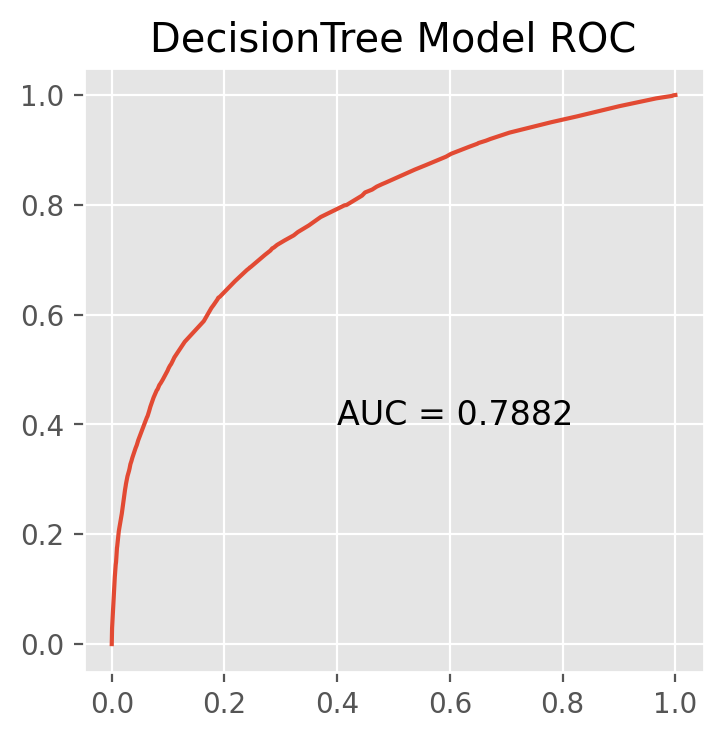

In [21]:
confirmed_tree_params = {'criterion': 'entropy',
                    'max_depth': 17,
                    'max_leaf_nodes': 141,
                    'class_weight': None,
                    'max_features': 'sqrt',
                    'min_samples_leaf': 1,
                    'min_samples_split': 6}
final_tree_model = DecisionTreeClassifier(**confirmed_tree_params)
start = time.time()
final_tree_model.fit(X_train,y_train)
last = time.time() - start

plt.figure(figsize=[4,4],dpi=200)
plt.style.use('ggplot')
fpr, recall, threshold = roc_curve(y_test, final_tree_model.predict_proba(X_test)[:,1], pos_label=1)
area = roc_auc_score(y_test, final_tree_model.predict_proba(X_test)[:,1])
plt.plot(fpr, recall)
plt.title('DecisionTree Model ROC')
plt.text(x=0.4, y=0.4, s='AUC = {:.4f}'.format(area), size=12)
plt.savefig('./pics/tree.jpg')
print('time: ',last)
print(final_tree_model.score(X_test,y_test))


In [70]:
final_svc_model.fit(X_train,y_train)


SVC(C=0.1, class_weight={}, degree=1, gamma=0.0001)

In [71]:
final_svc_model.score(X_test,y_test)

0.8419623611341402

time:  35.744877338409424
0.8417550986569391


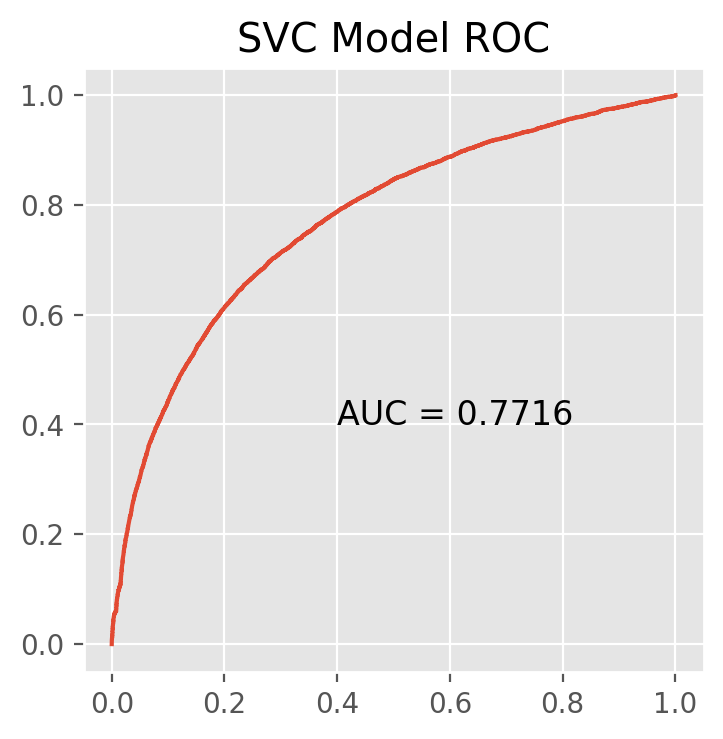

In [24]:
confirmed_svc_params = {'kernel': 'rbf', 'C': 0.1, 'gamma': 0.0001, 'degree': 1}
final_svc_model = SVC(**confirmed_svc_params)
start = time.time()
final_svc_model.fit(rb_X_train, rb_y_train)
last = time.time() - start

plt.figure(figsize=[4,4],dpi=200)
plt.style.use('ggplot')
# fpr, recall, threshold = roc_curve(rb_y_test, final_svc_model.decision_function(rb_X_test), pos_label=1)
# area = roc_auc_score(rb_y_test, final_svc_model.decision_function(rb_X_test))

fpr, recall, threshold = roc_curve(y_test, final_svc_model.decision_function(X_test), pos_label=1)
area = roc_auc_score(y_test, final_svc_model.decision_function(X_test))

plt.plot(fpr, recall)
# plt.plot(fpr1, recall1)
plt.title('SVC Model ROC')
plt.text(x=0.4, y=0.4, s='AUC = {:.4f}'.format(area), size=12)
plt.savefig('./pics/svc.jpg')
print('time: ',last)
print(final_svc_model.score(X_test,y_test))

time:  0.3676917552947998
0.8485118554136959


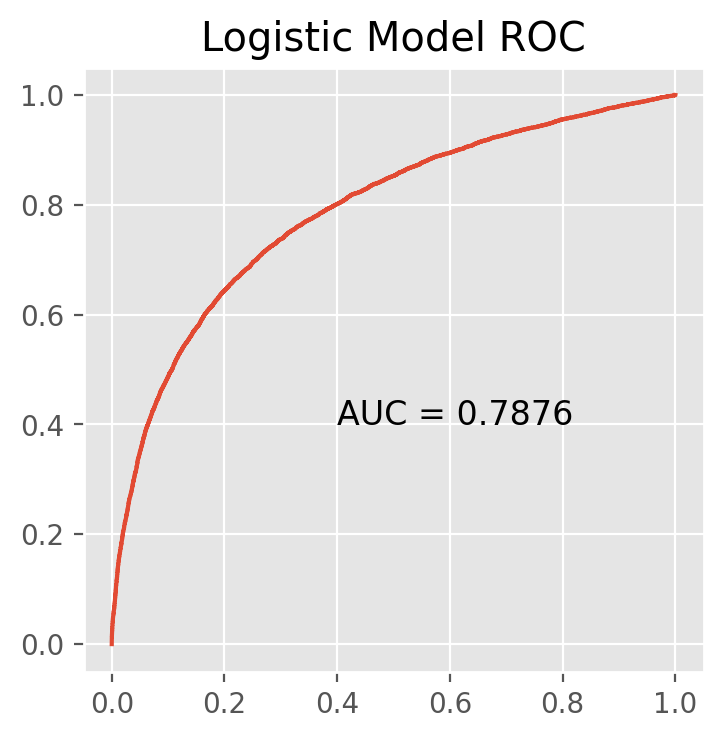

In [23]:
confirmed_logi_params = {'multi_class':'ovr'}
final_logi_model = LogisticRegression(**confirmed_logi_params)
start = time.time()
final_logi_model.fit(X_train,y_train)
last = time.time() - start

plt.figure(figsize=[4,4],dpi=200)
plt.style.use('ggplot')
fpr, recall, threshold = roc_curve(y_test, final_logi_model.predict_proba(X_test)[:,1], pos_label=1)
area = roc_auc_score(y_test, final_logi_model.predict_proba(X_test)[:,1])
plt.plot(fpr, recall)
plt.title('Logistic Model ROC')
plt.text(x=0.4, y=0.4, s='AUC = {:.4f}'.format(area), size=12)
plt.savefig('./pics/logistic.jpg')
print('time: ',last)
print(final_logi_model.score(X_test,y_test))

----
# 4.1其他数据集上

In [15]:
robust_data = pd.read_csv('./og_data/2.csv')
rb_X_train, rb_X_test, rb_y_train, rb_y_test, rb_train_data, rb_test_data = data_processing(robust_data)
df = pd.read_csv('./og_data/0.csv')
X_train, X_test, y_train, y_test, train_data, test_data = data_processing(df)

time:  35.744877338409424
0.8219200795887912


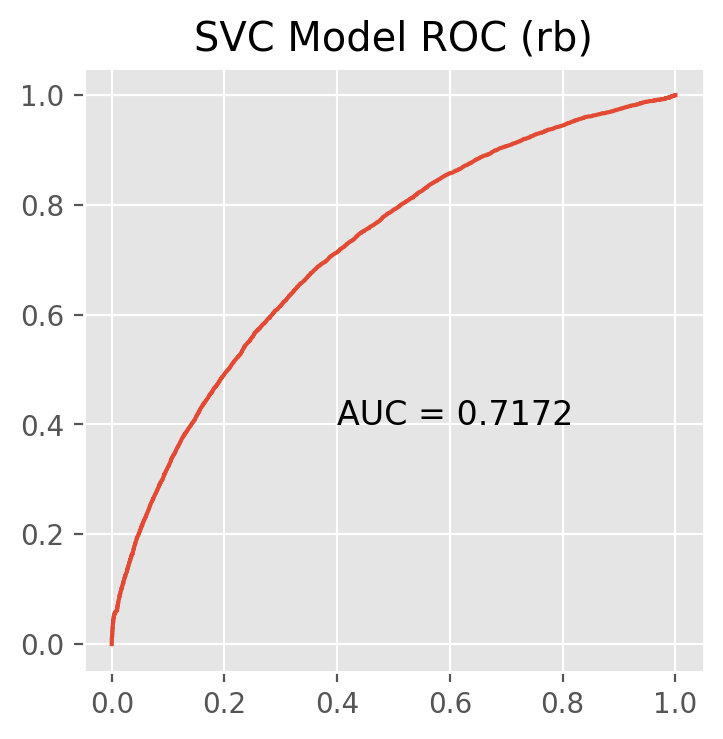

In [25]:
plt.figure(figsize=[4,4],dpi=200)
plt.style.use('ggplot')
fpr, recall, threshold = roc_curve(rb_y_test, final_svc_model.decision_function(rb_X_test), pos_label=1)
area = roc_auc_score(rb_y_test, final_svc_model.decision_function(rb_X_test))
plt.plot(fpr, recall)
plt.title('SVC Model ROC (rb)')
plt.text(x=0.4, y=0.4, s='AUC = {:.4f}'.format(area), size=12)
plt.savefig('./pics/rb_svc.jpg')
print('time: ',last)
print(final_svc_model.score(rb_X_test,rb_y_test))

time:  35.744877338409424
0.8295473387497927


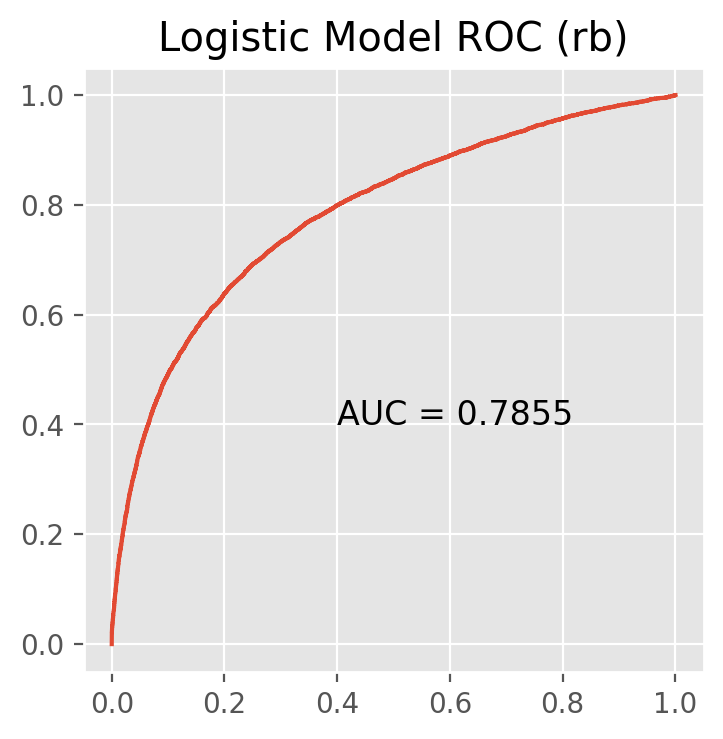

In [26]:
plt.figure(figsize=[4,4],dpi=200)
plt.style.use('ggplot')
fpr, recall, threshold = roc_curve(rb_y_test, final_logi_model.predict_proba(rb_X_test)[:,1], pos_label=1)
area = roc_auc_score(rb_y_test, final_logi_model.predict_proba(rb_X_test)[:,1])
plt.plot(fpr, recall)
plt.title('Logistic Model ROC (rb)')
plt.text(x=0.4, y=0.4, s='AUC = {:.4f}'.format(area), size=12)
plt.savefig('./pics/rb_logistic.jpg')
print('time: ',last)
print(final_logi_model.score(rb_X_test,rb_y_test))

time:  35.744877338409424
0.8494238103133809


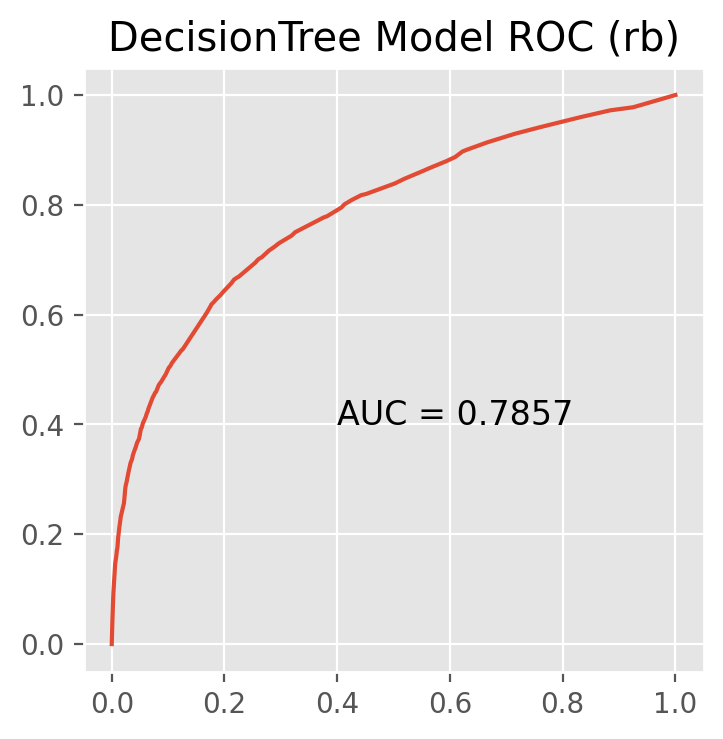

In [33]:
plt.figure(figsize=[4,4],dpi=200)
plt.style.use('ggplot')
fpr, recall, threshold = roc_curve(rb_y_test, final_tree_model.predict_proba(rb_X_test)[:,1], pos_label=1)
area = roc_auc_score(rb_y_test, final_tree_model.predict_proba(rb_X_test)[:,1])
plt.plot(fpr, recall)
plt.title('DecisionTree Model ROC (rb)')
plt.text(x=0.4, y=0.4, s='AUC = {:.4f}'.format(area), size=12)
plt.savefig('./pics/rb_tree.jpg')
print('time: ',last)
print(final_tree_model.score(rb_X_test,rb_y_test))

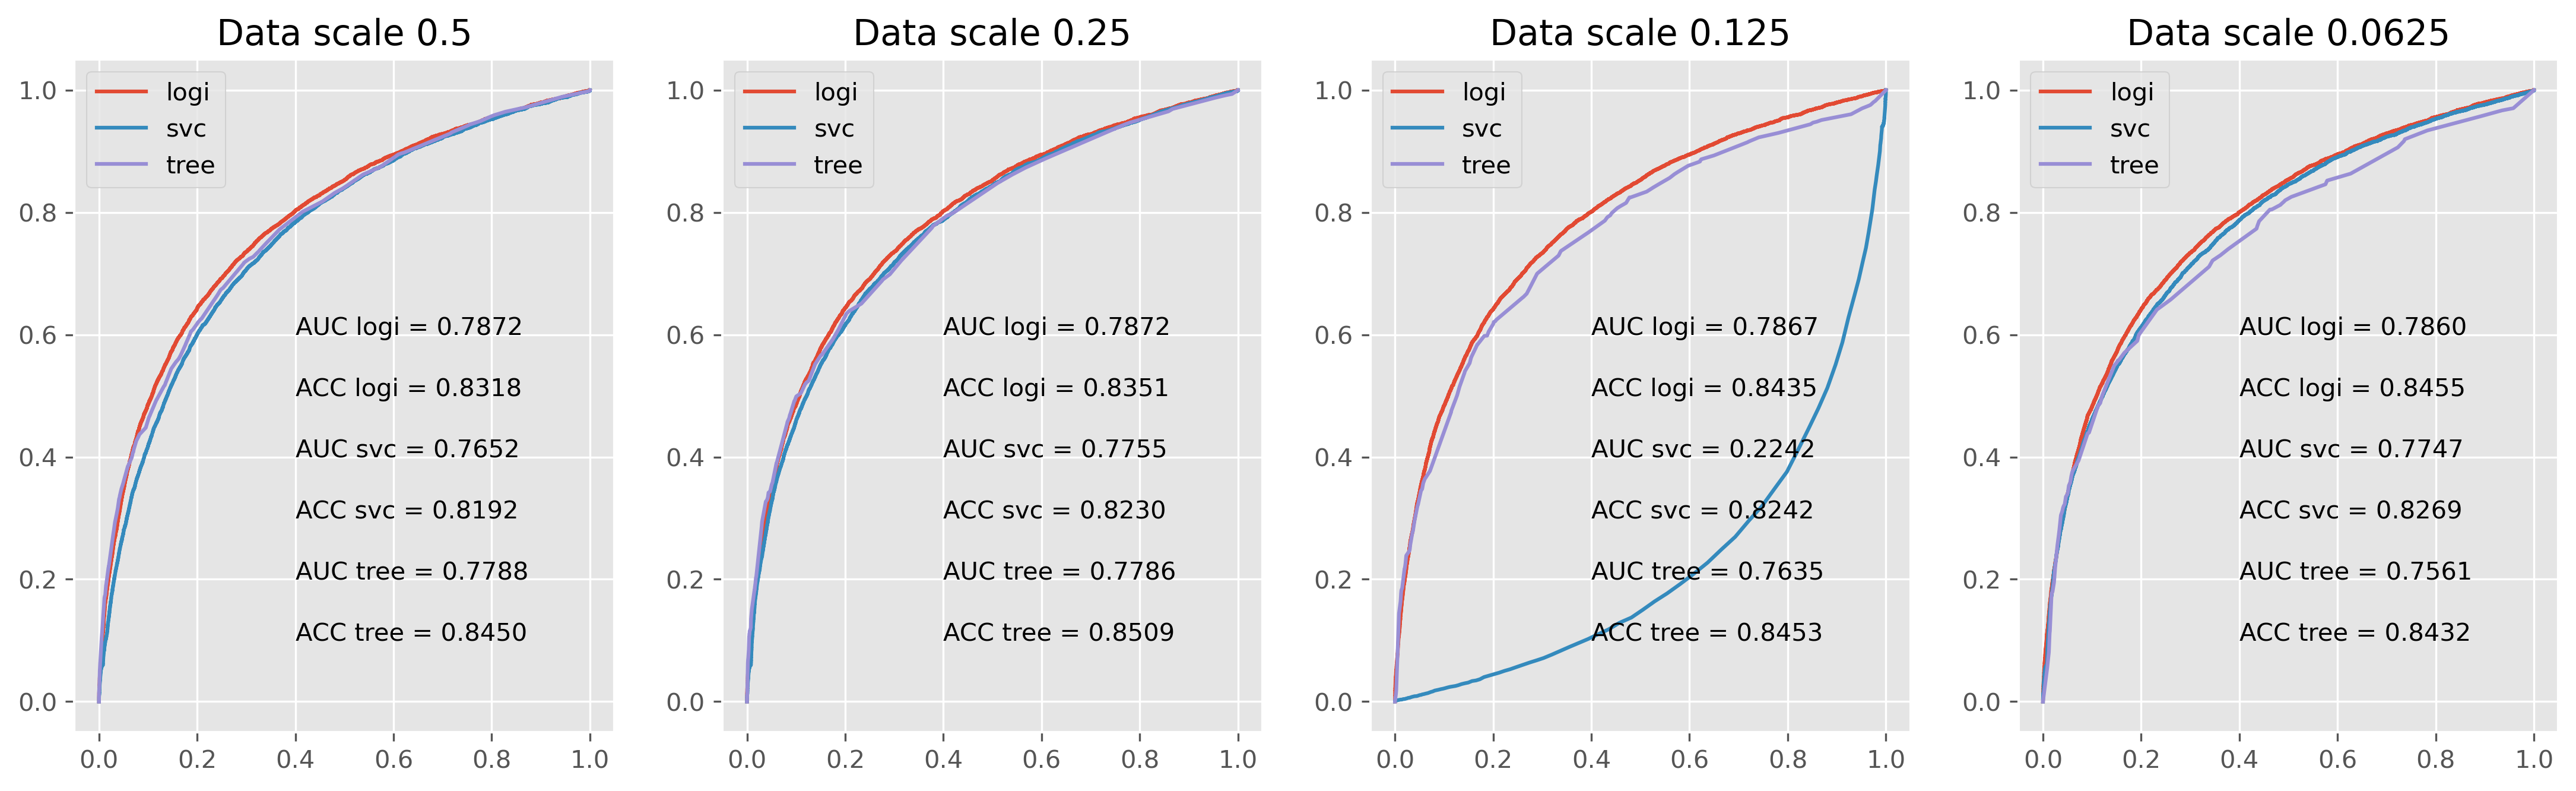

In [9]:
df = pd.read_csv('./og_data/0.csv')
X_train, X_test, y_train, y_test, train_data, test_data = data_processing(df)
plt.figure(figsize = [18,5],dpi=300)
for i in range(1,5):
    per = (0.5)**i
    robust_data = pd.read_csv('./og_data/2.csv')
    robust_data = robust_data.sample(int(len(robust_data)*per),random_state=42)
    rb_X_train, rb_X_test, rb_y_train, rb_y_test, rb_train_data, rb_test_data = data_processing(robust_data)
    
    confirmed_logi_params = {'multi_class':'ovr'}
    final_logi_model = LogisticRegression(**confirmed_logi_params)
    final_logi_model.fit(rb_X_train,rb_y_train)
    score0 = final_logi_model.score(rb_X_test,rb_y_test)
    
    confirmed_svc_params = {'kernel': 'rbf', 'C': 0.1, 'gamma': 0.0001, 'degree': 1, 'probability':True}
    final_svc_model1 = SVC(**confirmed_svc_params)
    final_svc_model1.fit(rb_X_train, rb_y_train)
    score1 = final_svc_model1.score(rb_X_test,rb_y_test)
    
    confirmed_tree_params = {'criterion': 'entropy',
                    'max_depth': 17,
                    'max_leaf_nodes': 141,
                    'class_weight': None,
                    'max_features': 'sqrt',
                    'min_samples_leaf': 1,
                    'min_samples_split': 6}
    final_tree_model = DecisionTreeClassifier(**confirmed_tree_params)
    final_tree_model.fit(rb_X_train,rb_y_train)
    score2 = final_tree_model.score(rb_X_test,rb_y_test)    

    
    # robust_data = pd.read_csv('./og_data/2.csv')
    # rb_X_train, rb_X_test, rb_y_train, rb_y_test, rb_train_data, rb_test_data = data_processing(robust_data)
    
    plt.style.use('ggplot')
    fpr1, recall1, threshold1 = roc_curve(y_test, final_svc_model1.predict_proba(X_test)[:,1], pos_label=1)
    area1 = roc_auc_score(y_test, final_svc_model1.predict_proba(X_test)[:,1])
    
    fpr0, recall0, threshold0 = roc_curve(y_test, final_logi_model.predict_proba(X_test)[:,1], pos_label=1)
    area0 = roc_auc_score(y_test, final_logi_model.predict_proba(X_test)[:,1])
    
    fpr2, recall2, threshold2 = roc_curve(y_test, final_tree_model.predict_proba(X_test)[:,1], pos_label=1)
    area2 = roc_auc_score(y_test, final_tree_model.predict_proba(X_test)[:,1])
    
    del final_svc_model1
    
    plt.subplot(1,4,i)
    plt.plot(fpr0, recall0,label='logi')
    plt.plot(fpr1, recall1,label='svc')
    plt.plot(fpr2, recall2,label='tree')
    plt.title('Data scale {}'.format(per))
    plt.text(x=0.4, y=0.6, s='AUC logi = {:.4f}'.format(area0), size=10)
    plt.text(x=0.4, y=0.5, s='ACC logi = {:.4f}'.format(score0), size=10)
    plt.text(x=0.4, y=0.4, s='AUC svc = {:.4f}'.format(area1), size=10)
    plt.text(x=0.4, y=0.3, s='ACC svc = {:.4f}'.format(score1), size=10)
    plt.text(x=0.4, y=0.2, s='AUC tree = {:.4f}'.format(area2), size=10)
    plt.text(x=0.4, y=0.1, s='ACC tree = {:.4f}'.format(score2), size=10)



    plt.legend()
plt.savefig('./pics/Data decreasing scale.jpg')

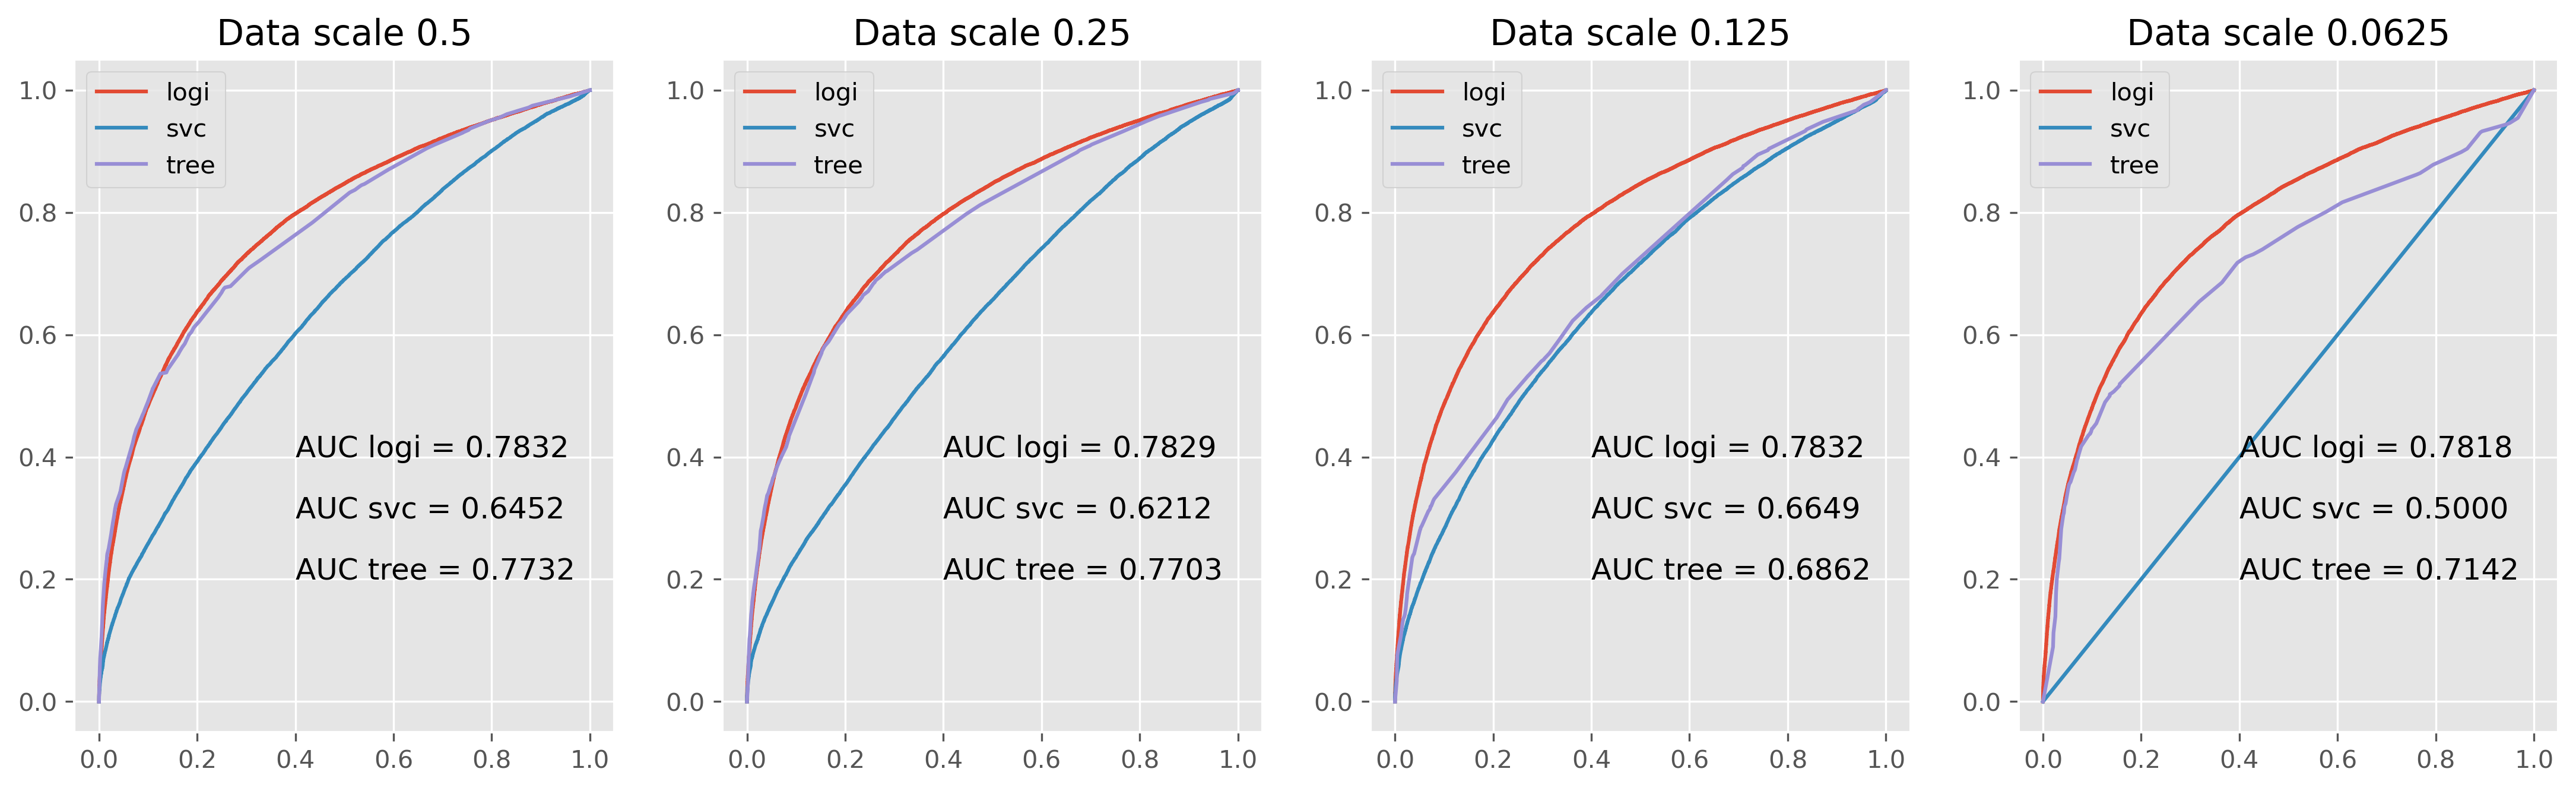

In [18]:


df = pd.read_csv('./og_data/0.csv')
X_train, X_test, y_train, y_test, train_data, test_data = unselect_data_processing(df)
plt.figure(figsize = [18,5],dpi=300)
for i in range(1,5):
    per = (0.5)**i
    robust_data = pd.read_csv('./og_data/2.csv')
    robust_data = robust_data.sample(int(len(robust_data)*per))
    rb_X_train, rb_X_test, rb_y_train, rb_y_test, rb_train_data, rb_test_data = unselect_data_processing(robust_data)
    
    confirmed_logi_params = {'multi_class':'ovr'}
    final_logi_model = LogisticRegression(**confirmed_logi_params)
    final_logi_model.fit(rb_X_train,rb_y_train)
    
    confirmed_svc_params = {'kernel': 'rbf', 'C': 0.1, 'gamma': 0.0001, 'degree': 1, 'probability':True}
    final_svc_model1 = SVC(**confirmed_svc_params)
    final_svc_model1.fit(rb_X_train, rb_y_train)
    
    confirmed_tree_params = {'criterion': 'entropy',
                    'max_depth': 17,
                    'max_leaf_nodes': 141,
                    'class_weight': None,
                    'max_features': 'sqrt',
                    'min_samples_leaf': 1,
                    'min_samples_split': 6}
    final_tree_model = DecisionTreeClassifier(**confirmed_tree_params)
    final_tree_model.fit(rb_X_train,rb_y_train)
    
    # robust_data = pd.read_csv('./og_data/2.csv')
    # rb_X_train, rb_X_test, rb_y_train, rb_y_test, rb_train_data, rb_test_data = data_processing(robust_data)
    
    plt.style.use('ggplot')
    fpr0, recall0, threshold0 = roc_curve(y_train, final_logi_model.predict_proba(X_train)[:,1], pos_label=1)
    area0 = roc_auc_score(y_train, final_logi_model.predict_proba(X_train)[:,1])
    
    fpr1, recall1, threshold1 = roc_curve(y_train, final_svc_model1.predict_proba(X_train)[:,1], pos_label=1)
    area1 = roc_auc_score(y_train, final_svc_model1.predict_proba(X_train)[:,1])
    
    fpr2, recall2, threshold2 = roc_curve(y_train, final_tree_model.predict_proba(X_train)[:,1], pos_label=1)
    area2 = roc_auc_score(y_train, final_tree_model.predict_proba(X_train)[:,1])
    
    # fpr0, recall0, threshold0 = roc_curve(rb_y_train, final_logi_model.predict_proba(rb_X_train)[:,1], pos_label=1)
    # area0 = roc_auc_score(rb_y_train, final_logi_model.predict_proba(rb_X_train)[:,1])
    
    # fpr1, recall1, threshold1 = roc_curve(rb_y_train, final_svc_model1.predict_proba(rb_X_train)[:,1], pos_label=1)
    # area1 = roc_auc_score(rb_y_train, final_svc_model1.predict_proba(rb_X_train)[:,1])
    
    # fpr2, recall2, threshold2 = roc_curve(rb_y_train, final_tree_model.predict_proba(rb_X_train)[:,1], pos_label=1)
    # area2 = roc_auc_score(rb_y_train, final_tree_model.predict_proba(rb_X_train)[:,1])
    
    del final_svc_model1
    
    plt.subplot(1,4,i)
    plt.plot(fpr0, recall0,label='logi')
    plt.plot(fpr1, recall1,label='svc')
    plt.plot(fpr2, recall2,label='tree')
    plt.title('Data scale {}'.format(per))
    plt.text(x=0.4, y=0.4, s='AUC logi = {:.4f}'.format(area0), size=12)
    plt.text(x=0.4, y=0.3, s='AUC svc = {:.4f}'.format(area1), size=12)
    plt.text(x=0.4, y=0.2, s='AUC tree = {:.4f}'.format(area2), size=12)
    plt.legend()
plt.savefig('./pics/Data decreasing scale (all features).jpg')

In [17]:
final_logi_model.predict_proba(rb_X_train)[:,1]

array([0.37593271, 0.08343991, 0.33760158, ..., 0.29809148, 0.00759466,
       0.25982048])

In [16]:
confirmed_svc_params = {'kernel': 'rbf', 'C': 0.1, 'gamma': 0.0001, 'degree': 1}
final_svc_model1 = SVC(**confirmed_svc_params)
final_svc_model1.fit(rb_X_train, rb_y_train)


array([[-0.99998015],
       [-0.99992454],
       [-0.99981648],
       ...,
       [-0.99989408],
       [-1.0002749 ],
       [-1.0001148 ]])

In [18]:
why = final_svc_model1.decision_function(rb_X_train)

In [19]:
why = np.array(why)

In [22]:
why = why.flatten()

In [23]:
why

array([-0.99998015, -0.99992454, -0.99981648, ..., -0.99989408,
       -1.0002749 , -1.0001148 ])

In [26]:
sum(why<0)

189863